In [1]:
from big_helper import *
from skimage.color import rgb2gray
from math import prod
from tqdm import tqdm

name = 'baby'
num = 36
size = (28,28)
N = prod(size)
make_bw = True

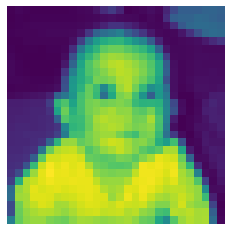

In [2]:
imgs = get_images(name, num, size) 
if name == 'TEXCOL':
    imgs = [img[0] for img in imgs] # 0 img, 1 colour mask, 2 texture mask


if make_bw == True:
    imgs = [rgb2gray(img) for img in imgs]

plt.rcParams["figure.figsize"] = (5,5)
plot_images(imgs)

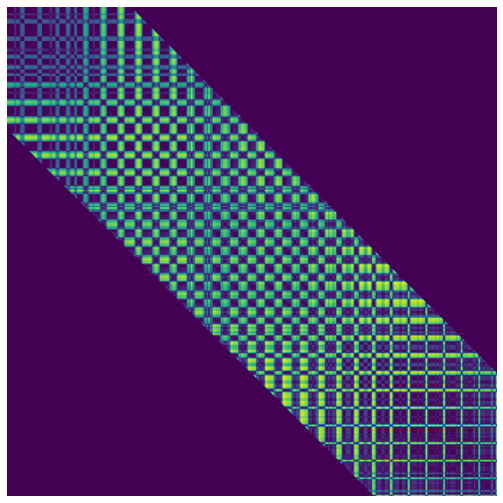

In [3]:
radius = N // 4
sigmaI = 0.1
sigmaX = 0.5

choice = 1
choices = ["manual_weights_binary", "manual_weights_abs", "intensity_weight_matrix", "weights_2", 
           "positional_weight_matrix", "intens_posit_wm", "weight_tot", "weight_int", "weight_dist",
           "generic_weight+texture", "generic_weight+colour", "generic_weight_noexp+texture", "generic_weight_noexp+colour",
           "generic_weight_rawfunc+texture", "generic_weight_rawfunc+colour", "manual_weights_abs_upper"]

singleImage = False

# TODO: fix weight int and the new ones :)

if singleImage:
    labels = []
    weights = []
    for i in tqdm(range(16)):
        labels.append(choices[i])
        weights.append(get_weights(imgs[0], i, radius, sigmaI, sigmaX))
else:
    labels = None
    weights = [get_weights(img, choice, radius, sigmaI, sigmaX) for img in imgs]
    
plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
plot_images(weights, labels)

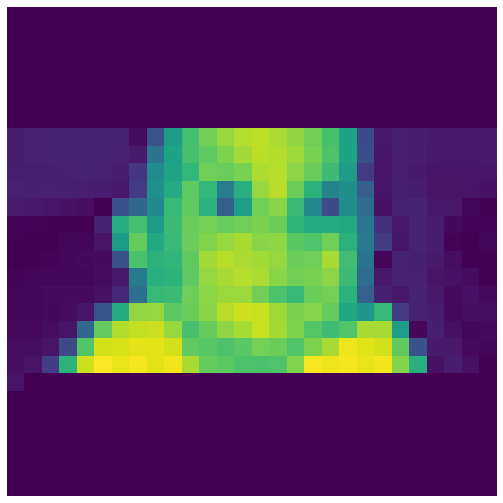

In [4]:
# plot a weight row as an image... should highlight the similar pixels
plot_1 = True
plot_2 = plot_3 = False

if plot_1:
    row = N // 2
    images = []
    for weight in weights:
        images.append(weight[row].reshape(size))
        
    plot_images(images, labels) 

if plot_2:
    row = N // 4
    images = []
    for weight in weights:
        images.append(weight[row].reshape(size))

    plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
    plot_images(images, labels) 

if plot_3:
    row = round(0.9 * N)
    images = []
    for weight in weights:
        images.append(weight[row].reshape(size))

    plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
    plot_images(images, labels) 

In [5]:
example = [norm_weights, ]

In [16]:
# quick and dirty solve test

# TODO: add sparse linalg ones
standard, generalized = get_eigensolvers()

vals = []
vals_spectrum = []
vecs = []
vecs_flat = []
labels = []


std = False
gen = True
lobpcg = True

np.random.seed(0)
for W in weights:
    d = np.sum(W,0)
    D = np.diag(d)
    
    if std:
        for name, func in standard.items():
            try:
                val, vec = func((D-W))
                
                index = argmin2(val)
                
                vecs_flat.append(vec[index])
                vecs.append(np.real(vec[index].reshape(size)))
                vals.append(np.real(val[index]))
                vals_spectrum.append(np.real(val))
                labels.append(name)
                print(f'{name} : val[{index}]={vals[-1]}')
            except Exception as err:
                print(f'{name } : {err}')
                continue
    
    if gen:
        for name, func in generalized.items():
            try:
                val, vec = func((D-W), D)
                
                index = argmin2(val)
                
                vecs_flat.append(vec[index])
                vecs.append(np.real(vec[index].reshape(size)))
                vals.append(np.real(val[index]))
                vals_spectrum.append(np.real(val))
                labels.append(name)
                print(f'{name} : val[{index}]={vals[-1]}')
            except Exception as err:
                print(f'{name } : {err}')
                continue
            
    if lobpcg:
        # also do lobpcg by hand since it needs an approximation vector X also included
        # can do generalized and standard forms.
        # lobpcg(A,X,B) or lobpcg(A,X), depending on the inputs feed to it :)
        import scipy.sparse.linalg as sparse
        X_2 = np.random.uniform(size=(N, 2))
        X_10 = np.random.uniform(size=(N, 10))

        A = D-W
        B = D
        
        if gen:
            name = "sparse A,X_2,B"
            w_1,v_1 = sparse.lobpcg(A, X_2, B, largest=False)
            index = argmin2(w_1)
            vecs.append(np.real(v_1[index].reshape(size)))
            labels.append(name)
            print(f'{name} : val[{index}]={vals[-1]}')
            
            name = "sparse A,X_10,B"
            w_2, v_2 = sparse.lobpcg(A, X_10, B, largest=False)
            index = argmin2(w_2)
            vecs.append(np.real(v_2[index].reshape(size)))
            labels.append(name)
        if std:
            # TODO: make this match above
            # w_1, v_1 = sparse.lobpcg(A, X_2, largest=False)
            # index = argmin2(w_1)
            # vecs.append(np.real(v_1[index].reshape(size)))
            # labels.append(f'sparse A,X_2 [{index}]')
            # w_2, v_2 = sparse.lobpcg(A, X_10, largest=False)
            # index = argmin2(w_2)
            # vecs.append(np.real(v_2[index].reshape(size)))
            # labels.append(f'sparse A,X_10 [{index}]')

g_eig : val[1]=0.15467443228520966
g_eigh_cff : val[1]=0.15467443228521002
g_eigh_gv : val[1]=0.1546744322852104
g_eigh_gvd : val[1]=0.1546744322852104
g_eigh_gvx_inf5 : val[1]=0.15467443228520972
g_eigh_gvx_inf10 : val[1]=0.15467443228520972
g_eigh_gvx_inf100 : val[1]=0.15467443228520972


ValueError: cannot reshape array of size 2 into shape (28,28)

In [15]:
# plot_images(vecs, labels)
# plot_images(np.sign(vecs), labels)


# plot_range(vals_spectrum, 'Eigenvalues')
# plot_range(vecs_flat, 'Eigenvectors')

In [9]:
# different valid image sets
# (real images too?)

# different weighting functions
# intens, position, affinity, intens * position...

# plot specific rows of the weights matrix (e.g. for intensity should show similar things in image)

# different weightings with W/np.max(W) (e.g. do we normalize the weights before doing laplace?)

# different laplace solvers
# cheap, expensive, symmetric/none...
# how to handle 0's in D? or... how to handle 0's in d?

# different eigensolvers
# initially try for just one eig solver?
# Time the eigensolvers

# linalg.eig(L)
# np.eig(L)

# linalg.eigh(L)
# linalg.eig(L)
# linalg.eigh(L,D)
# linalg.eig(L,D)
# plus the gvd variants etc....

# lobpcg (specifically setup for finding small eigenvalues unlike most other methods :) )

# outputs
# and with... * 28, * eigval, * np.sqrt(D)
# sign of outputs to make it an indicator vector
# objective, eqconst

# plot the eigenvalues for a different method... (see if > 0)
# plot the eigenvectors for different inputs
# plot ncut cost, at different partitions of the eigenvector range
# ^ and do this for the first so many eigenvectors :)

# also other plots probably mentioned in eigs-test2 or nc-test2/nc-test3... etc